In [2]:
import networkx as nx
import networkx.algorithms.community as nxcom
from networkx.algorithms.community.centrality import girvan_newman
import scipy.stats as sp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import math
from scipy.special import factorial

# A05.1 Scale-Free Networks

In [3]:
# read data
data_path = '/Users/luojiayu/Downloads/semester1/Network Science/Assignments/Assignment5/data-assignment5/'

name_list = [
    'graph_amazon',
    'graph_escort',
    'graph_internet'
]
all_graph = dict()

for name in name_list:
    graph_real = nx.read_gml(data_path+name+".gml")
    
    all_graph[name] = graph_real
    

##  graph_amazon ## 
sigma: 0.38278871492805033
D: 0.06336204071074403

##  graph_escort ## 
sigma: 0.4729004708388648
D: 0.07888785302682838

##  graph_internet ## 
sigma: 0.2567249069964045
D: 0.06201767421187254



/Users/luojiayu/opt/anaconda3/envs/ds_exercise/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in double_scalars
/Users/luojiayu/opt/anaconda3/envs/ds_exercise/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


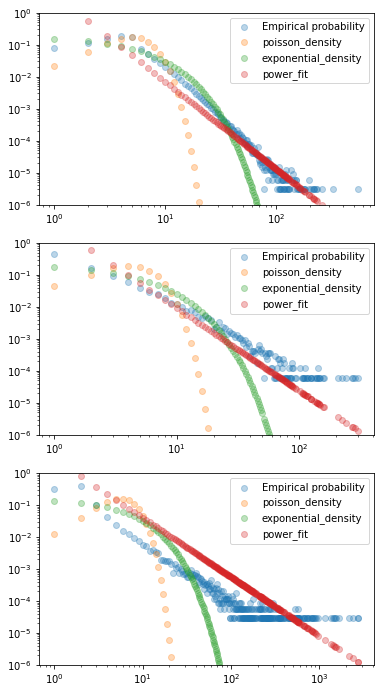

In [39]:
from collections import Counter

fig, axes = plt.subplots(nrows = 3, figsize=(6, 12)) 
index = 0
for graph_name in all_graph:
    print('## ',graph_name,'## ')
    
    g = all_graph[graph_name]
    
    degree = [degree for label, degree in g.degree()]
    avg_degree = np.mean(degree)
    
    counter_degree = Counter(degree)
    counter_degree = {k: v for k, v in sorted(counter_degree.items(), key=lambda item: item[0])}
    
    degree_list = list(counter_degree.keys())
    
    # Empirical probability
    total_frequency = sum(counter_degree.values())
    relative_frequency = list()
    
    for v in counter_degree.values():
        relative_frequency.append(v/total_frequency)
    
    # poisson, exp
    poisson_density = list()
    exp_density = list()
    
    for k in degree_list:
        poisson_density.append((avg_degree**k)*(math.exp(-avg_degree))/factorial(k, exact=False)) 
        exp_density.append((1/avg_degree)*(math.exp(-k/avg_degree)))
    
    # power law fit
    import powerlaw
    fit = powerlaw.Fit(degree_list)
    alpha = fit.power_law.alpha
    power_fit = alpha*degree_list**(1-alpha)
    sigma = fit.power_law.sigma
    D = fit.power_law.D
    print('sigma:', sigma)
    print('D:', D)
    print()
        
    # draw
    axes[index].scatter(x=degree_list, y=relative_frequency, alpha=0.3,)
    axes[index].scatter(x=degree_list, y=poisson_density, alpha=0.3,)
    axes[index].scatter(x=degree_list, y=exp_density, alpha=0.3,)
    axes[index].scatter(x=degree_list, y=power_fit, alpha=0.3,)
    
    axes[index].legend(['Empirical probability','poisson_density','exponential_density','power_fit'])
    axes[index].set_yscale('log')
    axes[index].set_xscale('log')
    axes[index].set_ylim([10**(-6), 1])
    
    index+=1
        
        

 **Which distribution is more likely to describe the data?**
 - power-law. Degree distribution follow power law.
 
 
 **What does it mean in practice for Amazon products?**
 - Products that people buy frequently only account for the small percentage of product categories. In other words, most products are bought with low frequency.

# A05.2 Barabási-Albert model

### change the number of nodes

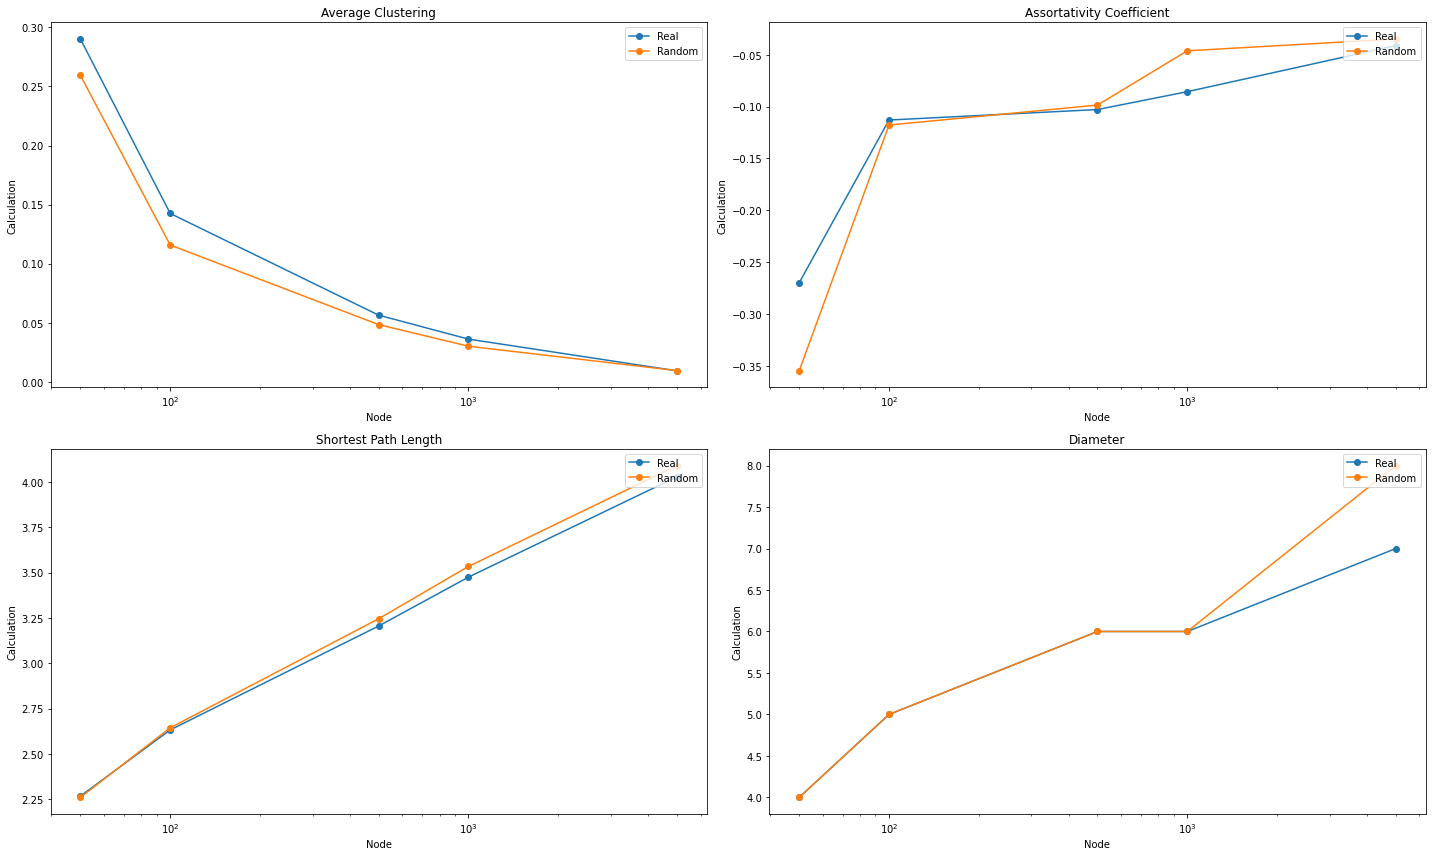

In [36]:

node_list =  [50, 100, 500, 1000, 5000 ]
fig, axs = plt.subplots(nrows = 2, ncols = 2,figsize=(20, 12))
ax_index = 0

clustering_real = list()
clustering_random = list()

assortativity_real = list()
assortativity_random = list()

path_real = list()
path_random = list()

diameter_real = list()
diameter_random = list()

for node in node_list:
    
    # real grah
    G_real = nx.barabasi_albert_graph(n=node, m=3)
    
    # generate random graph
    G_random = nx.algorithms.smallworld.random_reference(G_real)
    
    all_graph = {
        'real': G_real,
        'random':G_random
    }
    
    for g_name in all_graph:
        
        G = all_graph[g_name]

        # average clustering coefficient
        avg_clustering = nx.average_clustering(G)

        # assortativity
        assortativity = nx.degree_assortativity_coefficient(G)

        # average shortest path length
        shortest_path = nx.average_shortest_path_length(G)

        # diameter
        diameter = nx.diameter(G)
        
        if g_name=='real':
            clustering_real.append(avg_clustering)
            assortativity_real.append(assortativity)
            path_real.append(shortest_path)
            diameter_real.append(diameter)
        else:
            clustering_random.append(avg_clustering)
            assortativity_random.append(assortativity)
            path_random.append(shortest_path)
            diameter_random.append(diameter)
    

def draw_subaxe(name, row_index, col_index, real_list, random_list, node_list):
    
    axs[row_index][col_index].plot(node_list, real_list,marker='o')
    axs[row_index][col_index].plot(node_list, random_list,marker='o')

    axs[row_index][col_index].set(xlabel='Node',ylabel='Calculation')
    axs[row_index][col_index].set_title(name)
    
    axs[row_index][col_index].legend(['Real', 'Random'],loc="upper right")
    axs[row_index][col_index].set_xscale('log')

draw_subaxe('Average Clustering', 0, 0, clustering_real, clustering_random, node_list)
draw_subaxe('Assortativity Coefficient', 0, 1, assortativity_real, assortativity_random, node_list)
draw_subaxe('Shortest Path Length', 1, 0, path_real, path_random, node_list)
draw_subaxe('Diameter', 1, 1, diameter_real, diameter_random, node_list)
fig.tight_layout()
plt.show()

    
    

**Which of these measures is relatively unchanged by randomisation?**
- Shortest Path Length and diameter. In Barabási Albert model, highly connnected nodes tend to aquire more connnection. So average clustering and assortativity coefficient will change a lot.

### change the number of connections

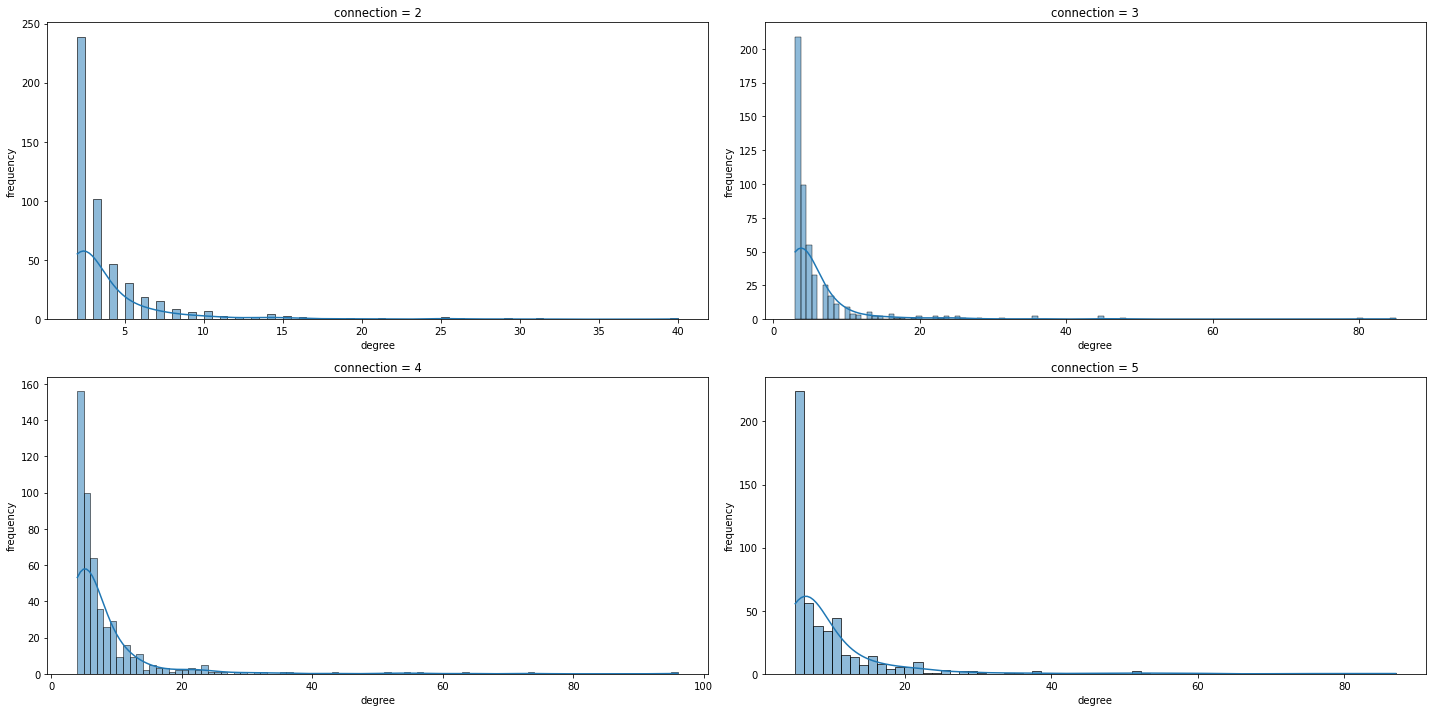

In [98]:
connection_list = [2, 3, 4, 5]

fig, axs = plt.subplots(nrows = 2, ncols = 2,figsize=(20, 10))
picture_index = 0

for connection in connection_list:
    
    G = nx.barabasi_albert_graph(n=500, m=connection)
    
    degree_list = [degree for label, degree in G.degree()]
    degree_arr = np.asarray(degree_list)
    
    row_index = picture_index//2
    col_index = picture_index%2
    
    sns.histplot(data=degree_arr, kde=True, ax=axs[row_index][col_index])
    axs[row_index][col_index].set(xlabel='degree', ylabel='frequency')
    axs[row_index][col_index].set_title('connection = '+str(connection), fontdict = {'fontsize' : 11.5})
    
    picture_index += 1

fig.tight_layout()
    

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Text(0.5, 1.0, 'relationship between alpha and connection (Node = 500)')

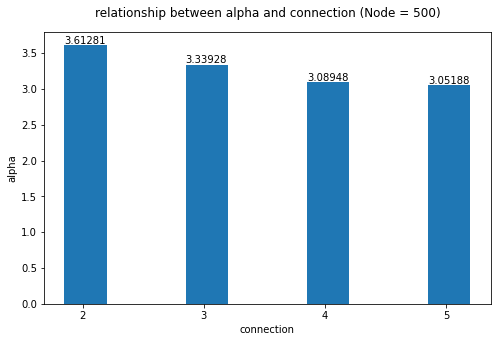

In [115]:
import powerlaw

connection_list = [2, 3, 4, 5]

alpha_list = list()

fig, axs = plt.subplots(figsize=(8, 5))

for connection in connection_list:
    
    G = nx.barabasi_albert_graph(n=500, m=connection)
    
    degree_list = [degree for label, degree in G.degree()]
    
    # power law fit
    fit = powerlaw.Fit(degree_list)
    alpha = fit.power_law.alpha
    alpha_list.append(alpha)

# draw graph
width = 0.35
x = np.arange(len(connection_list))
rects1 = axs.bar(x - width/2+0.2, alpha_list, width, label='real')

# show value
for bar in rects1:
    yval = bar.get_height()
    if yval>0:
        axs.text(x = bar.get_x(), y = yval+0.02, s =round(yval, 5))
    else:
        axs.text(x = bar.get_x(), y = yval+0.02, s =round(yval, 5))

axs.set(ylabel='alpha')
axs.set(xlabel='connection')
axs.set_xticks(x)
axs.set_xticklabels(connection_list)
axs.set_title('relationship between alpha and connection (Node = 500)', pad=15)
    